# Задача

Реализуем pipeline с использование текстовых признаков catboost.

# Импорты


In [1]:
from copy import deepcopy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, plot_roc_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold
from catboost import CatBoostClassifier
%matplotlib inline

from module.prepare_data import load_dataset, Preprocessor
from module.model import (
    get_cb_pipeline,
    TEXT_PROCESSING,
    save_pipeline,
    load_pipeline,
)

In [2]:
RANDOM_SEED = 35

pd.set_option('display.max_colwidth', 100)

# Данные

In [3]:
test_path = '../data/test.csv'
train_path = '../data/short_train.csv'

In [4]:
df = load_dataset(train_path)
test_df = load_dataset(test_path)

# Обучение

In [5]:
cb_params = {
    'text_features': ['text'],
    'text_processing': TEXT_PROCESSING,
    'iterations': 100,
}

In [6]:
cb_pipeline = get_cb_pipeline(cb_params)

In [7]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

In [8]:
cv_scores = cross_val_score(
    cb_pipeline,
    df[['text']],
    df['label'],
    cv=cv,
    n_jobs=5,
    scoring='roc_auc',
    verbose=1,
#     fit_params={'verbose': False}
)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   30.8s remaining:   46.2s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   30.9s finished


In [9]:
cv_scores

array([0.8752202 , 0.88294055, 0.88542286, 0.88144197, 0.88801323])

О, стало заметно лучше. Бейзлайна.

## А если без пропроцессинга?

In [10]:
text_processing = deepcopy(TEXT_PROCESSING)

In [11]:
text_processing["feature_processing"] = {
    "default": [{
            "dictionaries_names": [
                "Symbols_1",
                "Symbols_2",
                "Symbols_3",
                'Word',
                "BiGram",
                "TriGram",
            ],
            "feature_calcers": ["BoW"],
            "tokenizers_names": ["Sense"]
        }, {
            "dictionaries_names": ["Symbols_1", 'Word'],
            "feature_calcers": ["NaiveBayes"],
            "tokenizers_names": ["Sense"]
    }],
}

In [12]:
cb_params = {
    'text_features': ['text'],
    'text_processing': text_processing,
    'iterations': 100,
}

In [13]:
cb_pipeline = CatBoostClassifier(**cb_params)

In [14]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

In [15]:
cv_scores = cross_val_score(
    cb_pipeline,
    df[['text']],
    df['label'],
    cv=cv,
    n_jobs=5,
    scoring='roc_auc',
    verbose=1,
#     fit_params={'verbose': False}
)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   29.6s remaining:   44.3s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   29.7s finished


In [16]:
cv_scores

array([0.8656952 , 0.85889301, 0.86451546, 0.85999196, 0.86524132])

Ага, так получается хуже.

## А если получше обработку сделать?

In [17]:
text_processing = deepcopy(TEXT_PROCESSING)

In [18]:
text_processing["feature_processing"] = {
    "default": [{
            "dictionaries_names": [
                "Symbols_1",
                "Symbols_2",
                "Symbols_3",
                'Word',
                "BiGram",
                "TriGram",
            ],
            "feature_calcers": ["BoW"],
            "tokenizers_names": ["Space"]
        }, {
            "dictionaries_names": ["Symbols_1", 'Word'],
            "feature_calcers": ["NaiveBayes", 'BM25'],
            "tokenizers_names": ["Space"]
    }],
}

In [19]:
cb_params = {
    'text_features': ['text'],
    'text_processing': text_processing,
    'iterations': 100,
}

In [20]:
cb_pipeline = get_cb_pipeline(cb_params)

In [21]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

In [22]:
cv_scores = cross_val_score(
    cb_pipeline,
    df[['text']],
    df['label'],
    cv=cv,
    n_jobs=5,
    scoring='roc_auc',
    verbose=1,
#     fit_params={'verbose': False}
)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   31.5s remaining:   47.2s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   31.5s finished


In [23]:
cv_scores

array([0.8787248 , 0.88681534, 0.88543341, 0.88265743, 0.88977954])

Лучше не стало, всё так же.

## А если деревьев больше брать?

In [24]:
cb_params = {
    'text_features': ['text'],
    'text_processing': TEXT_PROCESSING,
    'iterations': 1000,
}

In [25]:
cb_pipeline = get_cb_pipeline(cb_params)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

In [26]:
cv_scores = cross_val_score(
    cb_pipeline,
    df[['text']],
    df['label'],
    cv=cv,
    n_jobs=5,
    scoring='roc_auc',
    verbose=1,
#     fit_params={'verbose': False}
)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  4.1min remaining:  6.2min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  4.1min finished


In [27]:
cv_scores

array([0.87809402, 0.88450086, 0.8875916 , 0.88360233, 0.88885738])

Забавно, это не слишком помогает.

## Итоговое обучение

In [28]:
cb_params = {
    'text_features': ['text'],
    'text_processing': TEXT_PROCESSING,
    'iterations': 100,
}

In [29]:
cb_pipeline = get_cb_pipeline(cb_params)

In [30]:
cb_pipeline.fit(df[['text']], df['label'])

Learning rate set to 0.238417
0:	learn: 0.6234507	total: 138ms	remaining: 13.7s
1:	learn: 0.5783289	total: 190ms	remaining: 9.3s
2:	learn: 0.5487682	total: 241ms	remaining: 7.79s
3:	learn: 0.5298199	total: 292ms	remaining: 7.02s
4:	learn: 0.5171517	total: 343ms	remaining: 6.52s
5:	learn: 0.5059533	total: 396ms	remaining: 6.21s
6:	learn: 0.4986358	total: 451ms	remaining: 5.99s
7:	learn: 0.4913056	total: 502ms	remaining: 5.77s
8:	learn: 0.4873710	total: 552ms	remaining: 5.58s
9:	learn: 0.4829641	total: 603ms	remaining: 5.43s
10:	learn: 0.4790995	total: 654ms	remaining: 5.29s
11:	learn: 0.4772968	total: 704ms	remaining: 5.16s
12:	learn: 0.4753079	total: 755ms	remaining: 5.05s
13:	learn: 0.4735989	total: 805ms	remaining: 4.94s
14:	learn: 0.4719344	total: 855ms	remaining: 4.84s
15:	learn: 0.4707942	total: 905ms	remaining: 4.75s
16:	learn: 0.4691704	total: 958ms	remaining: 4.67s
17:	learn: 0.4681852	total: 1.01s	remaining: 4.6s
18:	learn: 0.4672717	total: 1.06s	remaining: 4.52s
19:	learn: 0.

Pipeline(steps=[('preproc',
                 <module.prepare_data.Preprocessor object at 0x7f670212b630>),
                ('clf',
                 <catboost.core.CatBoostClassifier object at 0x7f670212b588>)])

## Проверка на отложенном датасете

In [31]:
test_label = test_df['label']

In [32]:
test_prediction = cb_pipeline.predict_proba(test_df[['text']])[:, 1]

In [33]:
roc_auc_score(test_label, test_prediction)

0.8855504018321223

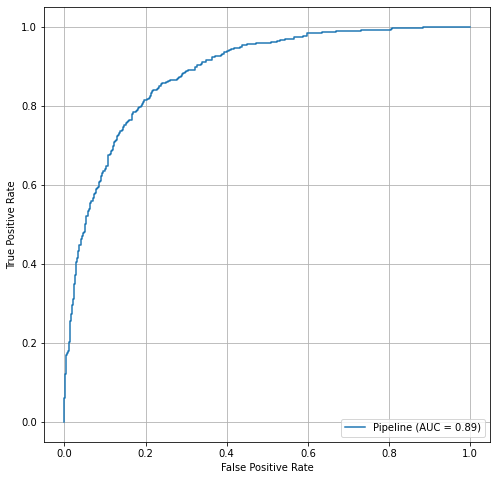

In [34]:
fg, ax = plt.subplots(1, 1, figsize=(8,8))
plot_roc_curve(cb_pipeline, test_df[['text']], test_label, ax=ax)
plt.grid()

###  Сохранение модели

In [35]:
model_path = '../models/model.pkl.gz'

In [36]:
save_pipeline(cb_pipeline, model_path)

In [37]:
restored_pipeline = load_pipeline(model_path)

In [38]:
restored_test_prediction = restored_pipeline.predict_proba(test_df[['text']])[:, 1]

In [39]:
assert (restored_test_prediction == test_prediction).all()

In [40]:
roc_auc_score(test_label, restored_test_prediction)

0.8855504018321223